In [1]:
#Imports some of the libraries that we will be using
import pandas as pd
import numpy as np
import math
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics
from sklearn import tree
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import time
warnings.filterwarnings('ignore')

In [2]:
from load_dataset import load
from classifier import NeuralNetwork, Logistic_Regression, SVM
from utils import *
from metrics import *  # include fairness and corresponding derivatives
from expl import explanation_candidate_generation, get_top_k_expl
from influence import *

['acs_income.csv', 'acs_influence_new.ipynb', 'adult.data', 'adult.test', 'adult_influence.ipynb', 'classifier.py', 'compas-scores-two-years.csv', 'compas_influence.ipynb', 'config.json', 'expl.py', 'functions.py', 'german.data', 'german_influence.ipynb', 'influence.py', 'load_dataset.py', 'loss.py', 'metrics.py', 'random_influence.ipynb', 'sqf_influence.ipynb', 'sqf_test.csv', 'sqf_train.csv', 'utils.py', '__pycache__']


<h4>Build model and get the influence points<h4>

In [3]:
dataset = 'german'
clf_name = 'Logistic_Regression'
metric = 0
support = 0.05
support_small = 0.3

In [4]:
X_train, X_test, y_train, y_test = load(dataset)

In [5]:
X_train

,status,duration,credit_hist,credit_amt,savings,employment,install_rate,debtors,residence,property,...,purpose_A42,purpose_A43,purpose_A44,purpose_A45,purpose_A46,purpose_A48,purpose_A49,housing_A151,housing_A152,housing_A153
0,3,1,2,0,4,3,4,0,4,2,...,False,False,False,False,False,False,False,True,False,False
1,3,0,2,1,4,4,4,0,3,1,...,False,False,False,False,False,False,False,False,True,False
2,2,1,2,1,1,2,1,0,1,1,...,False,False,False,False,False,False,False,False,True,False
3,0,0,2,0,2,0,1,0,2,2,...,False,False,False,False,False,False,False,True,False,False
4,0,1,2,1,0,2,2,0,2,3,...,False,True,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,3,0,2,1,4,1,1,0,4,3,...,False,False,False,False,False,False,False,True,False,False
796,0,0,0,0,0,4,3,0,4,0,...,False,False,False,False,False,False,False,False,False,True
797,3,1,1,1,0,1,1,0,2,2,...,False,False,False,False,False,False,False,False,True,False
798,0,1,2,0,0,0,4,0,2,1,...,False,True,False,False,False,False,False,False,True,False


In [6]:
duplicates = 1
make_duplicates = lambda x, d: pd.concat([x]*d, axis=0).reset_index(drop=True)
X_train = make_duplicates(X_train, duplicates)
X_test = make_duplicates(X_test, duplicates)
y_train = make_duplicates(y_train, duplicates)
y_test = make_duplicates(y_test, duplicates)

In [7]:
#list of solution times
sol_time = []

In [8]:
import copy
X_train_orig = copy.deepcopy(X_train)
X_test_orig = copy.deepcopy(X_test)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [9]:
clf = eval(clf_name)(input_size=X_train.shape[-1])

num_params = len(convert_grad_to_ndarray(list(clf.parameters())))
if isinstance(clf, Logistic_Regression):
    loss_func = logistic_loss_torch
elif isinstance(clf, SVM):
    loss_func = svm_loss_torch
elif isinstance(clf, NeuralNetwork):
    loss_func = nn_loss_torch
else:
    raise NotImplementedError

In [10]:
clf = eval(clf_name)(input_size=X_train.shape[-1])

clf.fit(X_train, y_train)

y_pred_test = clf.predict_proba(X_test)
y_pred_train = clf.predict_proba(X_train)

spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
print("Initial statistical parity: ", spd_0)

tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
print("Initial TPR parity: ", tpr_parity_0)

predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
print("Initial predictive parity: ", predictive_parity_0)

accuracy_0 = computeAccuracy(y_test, y_pred_test)
print("Initial accuracy: ", accuracy_0)

Initial statistical parity:  -0.09527579839341338
Initial TPR parity:  -0.07785149414194836
Initial predictive parity:  -0.10136869475949661
Initial accuracy:  0.755


<h4>Calculate Influence of original datapoints with original labels<h4>

In [11]:
if_start = time.time()
metric_val = [spd_0, tpr_parity_0, predictive_parity_0][metric]
del_F_del_theta = get_del_F_del_theta(clf, X_test_orig, X_test, y_test, dataset, metric)

In [12]:
print(metric_val)

-0.09527579839341338


In [13]:
hessian_all_points = get_hessian_all_points(clf, X_train, y_train, loss_func)

100%|██████████| 800/800 [00:14<00:00, 56.62it/s]


In [14]:
'''

Compute the offline and online times for the influence functions
Offline: Time taken for Hessian Computation
Online: Time taken to compute influence for each of the datapoints

Break this down in the time graph; rather than showing just the total time taken for influence flipping
Break it down by offline and online

'''

'\n\nCompute the offline and online times for the influence functions\nOffline: Time taken for Hessian Computation\nOnline: Time taken to compute influence for each of the datapoints\n\nBreak this down in the time graph; rather than showing just the total time taken for influence flipping\nBreak it down by offline and online\n\n'

In [15]:
del_L_del_theta = get_del_L_del_theta(clf, X_train, y_train, loss_func)

In [16]:
hinv_v, hinv = get_hinv_v(hessian_all_points, np.transpose(del_L_del_theta))
#incorporate del_l_del_theta_i with the updated datapoint

In [17]:
#Influence before applying the negative values
pre_negative_inf = np.matmul(np.transpose(hinv_v),del_F_del_theta)
pre_negative_inf = (-1/(len(X_train)+len(X_test)))*pre_negative_inf

In [18]:
#multiple the inverse by -1
negative_hinv_v = -1*hinv_v

In [19]:
inf = np.matmul(np.transpose(negative_hinv_v), del_F_del_theta)
#For the new datapoint re-calculate the hinv_v

In [20]:
inf = (-1/(len(X_train)+len(X_test))) *inf 

<h4>Calculated flipped the Normal way<h4>

In [21]:
#Flip all the labels for the encoded data and the scaled data
#The labels are the same just the training data looks different 
y_train_changed = y_train.replace({0:1,1:0})
#y_test_changed = y_test.replace({0:1,1:0})

In [22]:
clf = eval(clf_name)(input_size=X_train.shape[-1])

num_params = len(convert_grad_to_ndarray(list(clf.parameters())))
if isinstance(clf, Logistic_Regression):
    loss_func = logistic_loss_torch
elif isinstance(clf, SVM):
    loss_func = svm_loss_torch
elif isinstance(clf, NeuralNetwork):
    loss_func = nn_loss_torch
else:
    raise NotImplementedError

In [23]:
clf = eval(clf_name)(input_size=X_train.shape[-1])

clf.fit(X_train, y_train_changed)

y_pred_test = clf.predict_proba(X_test)
y_pred_train = clf.predict_proba(X_train)

spd_1 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
print("Initial statistical parity: ", spd_1)

tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
print("Initial TPR parity: ", tpr_parity_0)

predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
print("Initial predictive parity: ", predictive_parity_0)

accuracy_0 = computeAccuracy(y_test, y_pred_test)
print("Initial accuracy: ", accuracy_0)

Initial statistical parity:  0.09501853685360401
Initial TPR parity:  0.07762472527187081
Initial predictive parity:  -0.10818301552416576
Initial accuracy:  0.245


In [24]:
if_start = time.time()
metric_val = [spd_1, tpr_parity_0, predictive_parity_0][metric]
del_F_del_theta_2 = get_del_F_del_theta(clf, X_test_orig, X_test, y_test, dataset, metric)

In [25]:
hessian_all_points = get_hessian_all_points(clf, X_train, y_train_changed, loss_func)

100%|██████████| 800/800 [00:13<00:00, 57.43it/s]


In [26]:
'''

Compute the offline and online times for the influence functions
Offline: Time taken for Hessian Computation
Online: Time taken to compute influence for each of the datapoints

Break this down in the time graph; rather than showing just the total time taken for influence flipping
Break it down by offline and online

'''

'\n\nCompute the offline and online times for the influence functions\nOffline: Time taken for Hessian Computation\nOnline: Time taken to compute influence for each of the datapoints\n\nBreak this down in the time graph; rather than showing just the total time taken for influence flipping\nBreak it down by offline and online\n\n'

In [27]:
del_L_del_theta = get_del_L_del_theta(clf, X_train, y_train_changed, loss_func)

In [28]:
hinv_v_2, hinv_2 = get_hinv_v(hessian_all_points, np.transpose(del_L_del_theta))
#incorporate del_l_del_theta_i with the updated datapoint

In [29]:
pre_negative_inf2 = np.matmul(np.transpose(hinv_v_2),del_F_del_theta_2)
pre_negative_inf2 = (-1/(len(X_train)+len(X_test)))*pre_negative_inf2

In [30]:
negative_hinv_v = -1*hinv_v_2

In [31]:
inf2 = np.matmul(np.transpose(negative_hinv_v), del_F_del_theta_2)
#For the new datapoint re-calculate the hinv_v

In [32]:
inf2 = (-1/(len(X_train)+len(X_test))) *inf2 

<h4>Calculate the difference between the changed vs original<h4>

In [33]:
#Apply the multiplication of -1/n of the dataset for both influence lists
#Length of the dataset
n = len(X_test) + len(X_train)
#Influence of original datapoints
og_inf =(-1/n)*inf
#Influence of altered datapoints
changed_inf = (-1/n)*inf2

In [34]:
total_inf3 = pre_negative_inf2 - pre_negative_inf

In [35]:
#Calculate the total influence in one full step
total_inf2 = ((-1*1/n)*np.matmul(np.transpose(-1*hinv_v_2),del_F_del_theta_2)) - ((-1*1/n)*(np.matmul(np.transpose(-1*hinv_v),del_F_del_theta)))

In [36]:
total_inf = inf2 - inf
if_end = time.time()
if_time1 = if_start - if_end

In [37]:
print(max(total_inf))
print(min(total_inf))
print(len(total_inf))
print(type(total_inf))
print(total_inf.dtype)

0.009555880058520476
-0.005134349009965776
800
<class 'numpy.ndarray'>
float64


In [38]:
print(max(total_inf2))
print(min(total_inf2))
print(len(total_inf2))
print(type(total_inf2))
print(total_inf2.dtype)

0.009555880058520476
-0.005134349009965776
800
<class 'numpy.ndarray'>
float64


In [39]:
print(max(total_inf3))
print(min(total_inf3))
print(len(total_inf3))
print(type(total_inf3))
print(total_inf3.dtype)

0.005134349009965776
-0.009555880058520476
800
<class 'numpy.ndarray'>
float64


<h4>Flip the datapoints and remove the datapoints and compare the parity values<h4>

In [40]:

predictors = ['status', 'duration', 'credit_hist', 'credit_amt', 'savings',
       'employment', 'install_rate', 'debtors', 'residence', 'property', 'age',
       'install_plans', 'num_credits', 'job', 'num_liable', 'telephone',
       'foreign_worker', 'gender', 'purpose_A40', 'purpose_A41',
       'purpose_A410', 'purpose_A42', 'purpose_A43', 'purpose_A44',
       'purpose_A45', 'purpose_A46', 'purpose_A48', 'purpose_A49',
       'housing_A151', 'housing_A152', 'housing_A153']
target_var =['credit_risk']

In [41]:
#Function to run the logistic regression model based on classifier.py
def lr_model(training_df, test_attr_df, classifier):
    changed_df_labels = training_df.pop('credit_risk')
    changed_df_attr = training_df.to_numpy()

    classifier.fit(changed_df_attr,changed_df_labels.values)
    y_predicted = classifier.predict_proba(test_attr_df)

    training_df['credit_risk'] = changed_df_labels

    return y_predicted


In [42]:
#Combine x_train and y_train
#I combine these so that when I flip the labels I have one DF that I work with
#Rather than 2 numpy.ndarrays
train_demo_df = pd.DataFrame(X_train, columns = predictors)
train_outcome_df = y_train.to_frame()
train_outcome_df=train_outcome_df.rename(columns={'credit':'credit_risk'})
train_full_df = pd.concat([train_demo_df, train_outcome_df], axis=1)

In [43]:
#Removal 
copy_train = train_full_df.copy()
difference = []

for index in copy_train.index:
    df_dropped = copy_train.copy()
    df_dropped = copy_train.drop(index)
    #Run lr_model() to get predicted probabilities
    ypred = lr_model(df_dropped, X_test, clf)
    parity = computeFairness(ypred, X_test_orig, y_test, 0, dataset)
    
    parity = parity-spd_0

    difference.append(parity)
#This does not fall under the measuring the time taken to decide how long it will take for IF to work 

In [44]:
#Flipping
#Make the original flips to test for the parity after each flip 
actual_df_train = train_full_df.copy()
actual_parity_list = []

for index, row in actual_df_train.iterrows():
    if row['credit_risk'] == 1:
        #Flip the label at credit_risk = 1 to 0
        actual_df_train.at[index,'credit_risk'] = 0
        actual_pred = lr_model(actual_df_train, X_test, clf)
        actual_parity = computeFairness(actual_pred, X_test_orig, y_test, 0, dataset)
        actual_parity_list.append(actual_parity)
        actual_df_train.at[index,'credit_risk'] = 1
        
    elif row['credit_risk'] == 0:
        actual_df_train.at[index,'credit_risk'] = 1
        actual_pred = lr_model(actual_df_train, X_test, clf)
        actual_parity = computeFairness(actual_pred, X_test_orig, y_test, 0, dataset)
        actual_parity_list.append(actual_parity)
        actual_df_train.at[index,'credit_risk'] = 0

In [45]:
decimal_array3 = [format(num, '.10f') for num in total_inf3]
decimal_array3 = [float(num) for num in decimal_array3]

[-0.0002149403, 0.0012289269, 2.8318e-06, -0.0007372724, 0.0007326445, -2.2564e-06, -0.0001023724, -0.0002083344, -0.0019818815, 0.0009298976, -0.0004718955, 0.0001221884, -0.0018243271, -0.0029634867, 0.0015578186, 0.0015049971, 0.0009973385, 0.0013787451, -0.0025048967, -0.0004472225, -0.001720223, -0.0012149054, 0.0005824825, -0.000614704, -0.0011053901, 0.0013272512, -0.0012486251, 0.001480994, -0.0012312502, -0.0002952182, 0.0001989758, -0.0008943433, -0.0002230949, 0.0023627261, -0.0013655889, -0.0002217015, -0.0007713534, 0.0018216264, 0.0012865867, -0.0002892606, 0.000695576, -5.98549e-05, 0.0020228738, 0.0012336227, 0.0001107761, -0.0002906605, -0.0021359985, 0.0019512834, 1.15593e-05, -0.0001059044, -0.0003473159, -9.9761e-05, -0.0046527918, -0.0021149258, -0.0010550054, -0.0002199231, -0.0005246293, 0.0018819985, -0.0010500901, -0.0003996535, -0.0001140049, -0.0001116724, 0.0006535013, 0.0006324262, 0.0014425233, -1.0516e-05, -0.0017061766, -0.0005529694, -6.60478e-05, -0.00

In [54]:
decimal_array2 = [format(num, '.10f') for num in total_inf2]
decimal_array2 = [float(num) for num in decimal_array2]

In [55]:
decimal_array = [format(num, '.10f') for num in total_inf]
decimal_array = [float(num) for num in decimal_array]

<h4>Single Negative<h4>

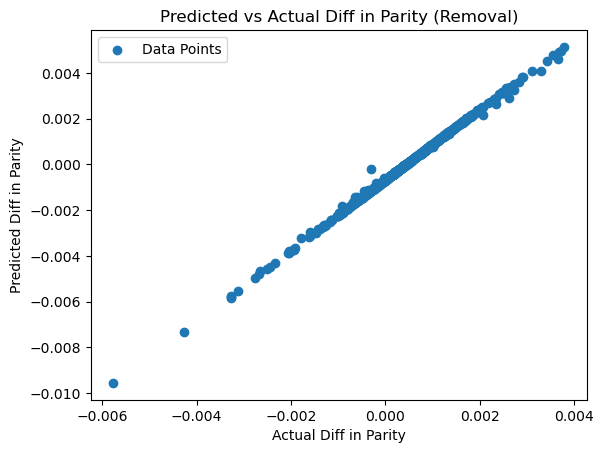

In [46]:
predicted_diff = decimal_array3
#actual_diff = actual_parity_list
actual_diff = difference

# Create the scatter plot
plt.scatter(actual_diff, predicted_diff, label='Data Points')

# Set the labels for the axes
plt.xlabel('Actual Diff in Parity')
plt.ylabel('Predicted Diff in Parity')

# Set the title of the plot (optional)
plt.title('Predicted vs Actual Diff in Parity (Removal)')

# Add a legend
plt.legend()

# Show the plot
plt.show()

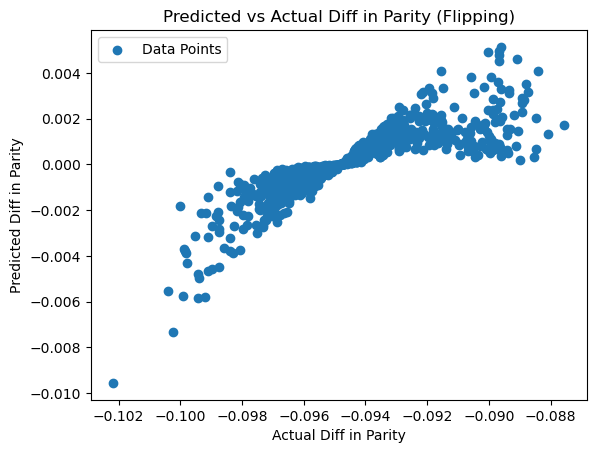

In [47]:
predicted_diff = decimal_array3
actual_diff = actual_parity_list
#actual_diff = difference

# Create the scatter plot
plt.scatter(actual_diff, predicted_diff, label='Data Points')

# Set the labels for the axes
plt.xlabel('Actual Diff in Parity')
plt.ylabel('Predicted Diff in Parity')

# Set the title of the plot (optional)
plt.title('Predicted vs Actual Diff in Parity (Flipping)')

# Add a legend
plt.legend()

# Show the plot
plt.show()

<h4>Multi-Step as Shown in Paper<h4>

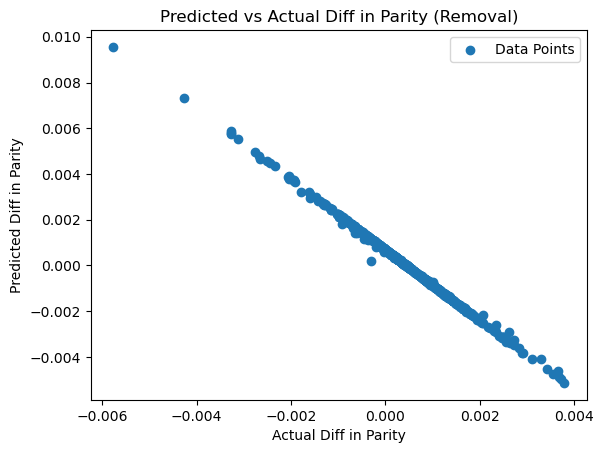

In [56]:
predicted_diff = decimal_array
#actual_diff = actual_parity_list
actual_diff = difference

# Create the scatter plot
plt.scatter(actual_diff, predicted_diff, label='Data Points')

# Set the labels for the axes
plt.xlabel('Actual Diff in Parity')
plt.ylabel('Predicted Diff in Parity')

# Set the title of the plot (optional)
plt.title('Predicted vs Actual Diff in Parity (Removal)')

# Add a legend
plt.legend()

# Show the plot
plt.show()

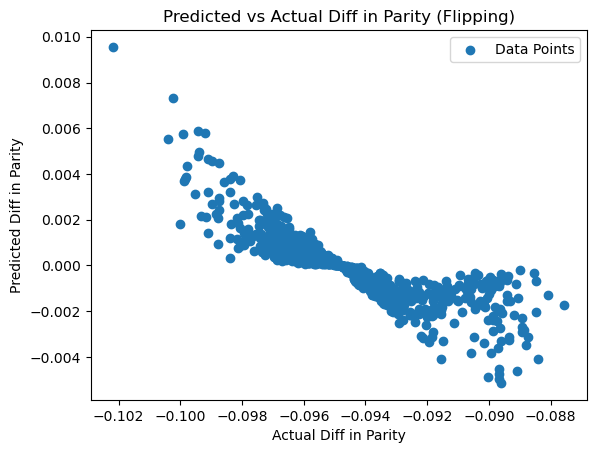

In [57]:
predicted_diff = decimal_array
actual_diff = actual_parity_list
#actual_diff = difference

# Create the scatter plot
plt.scatter(actual_diff, predicted_diff, label='Data Points')

# Set the labels for the axes
plt.xlabel('Actual Diff in Parity')
plt.ylabel('Predicted Diff in Parity')

# Set the title of the plot (optional)
plt.title('Predicted vs Actual Diff in Parity (Flipping)')

# Add a legend
plt.legend()

# Show the plot
plt.show()

<h4>Single Step as Shown in Paper<h4>

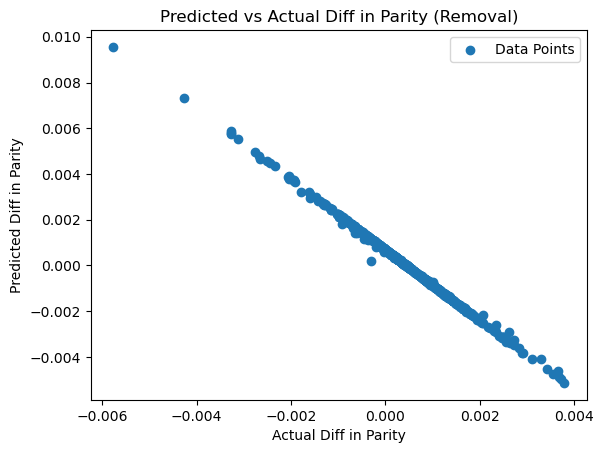

In [58]:
predicted_diff = decimal_array2
#actual_diff = actual_parity_list
actual_diff = difference

# Create the scatter plot
plt.scatter(actual_diff, predicted_diff, label='Data Points')

# Set the labels for the axes
plt.xlabel('Actual Diff in Parity')
plt.ylabel('Predicted Diff in Parity')

# Set the title of the plot (optional)
plt.title('Predicted vs Actual Diff in Parity (Removal)')

# Add a legend
plt.legend()

# Show the plot
plt.show()

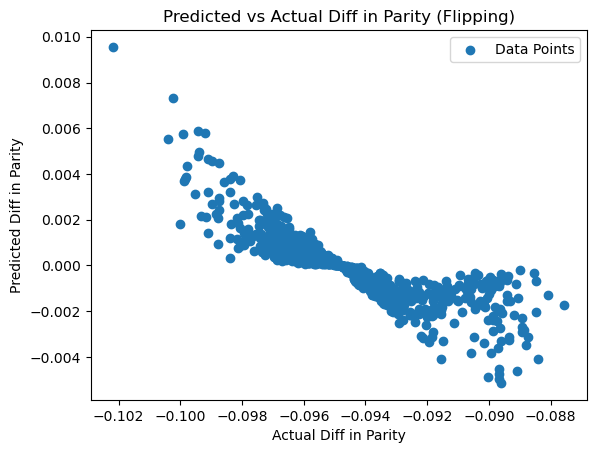

In [59]:
predicted_diff = decimal_array2
actual_diff = actual_parity_list
#actual_diff = difference

# Create the scatter plot
plt.scatter(actual_diff, predicted_diff, label='Data Points')

# Set the labels for the axes
plt.xlabel('Actual Diff in Parity')
plt.ylabel('Predicted Diff in Parity')

# Set the title of the plot (optional)
plt.title('Predicted vs Actual Diff in Parity (Flipping)')

# Add a legend
plt.legend()

# Show the plot
plt.show()

<h3>##########################################################################################<h3>

<h4>Make flips based on the total_inf value<h4>

In [48]:
if_start = time.time()
index_list = []
for i in range(800):
    index_list.append(i)

In [49]:
#Make a copy of the training data to make flips on 
influence_train_copy = train_full_df.copy()

In [50]:
#Order the total_inf in descending order based on magnitude
combined_list = list(zip(total_inf, index_list))

# Step 2: Sort the combined list based on the float values
sorted_combined_list = sorted(combined_list, key=lambda x: abs(x[0]), reverse=True)

# Step 3: Unpack the sorted list of tuples back into two separate lists
abs_sorted_float_list, abs_sorted_index_list = zip(*sorted_combined_list)
list(abs_sorted_float_list)
list(abs_sorted_index_list)
#Measure up to here for the influence functions
#This will tell us how long it takes for influence functions to determine which order I need to flip the datapoints in
#if_time: Time taken to decide the order in which the datapoints need to be flipped
if_end = time.time()
if_time2 = if_end-if_start
if_time2 += if_time1
print(if_time2)

-14.48833703994751


In [51]:
if if_time2 < 0:
    if_time2 = -1 * if_time2
else: 
    pass

In [52]:
flip_parity_abs = []
for i in range(len(abs_sorted_index_list)):
    row_num = abs_sorted_index_list[i]
    if influence_train_copy.at[row_num,'credit_risk'] == 1:
        influence_train_copy.at[row_num,'credit_risk'] = 0
        influence_prediction = lr_model(influence_train_copy, X_test, clf)
        influence_parity = computeFairness(influence_prediction, X_test_orig, y_test, 0, dataset)
        flip_parity_abs.append(influence_parity)
    elif influence_train_copy.at[row_num,'credit_risk'] == 0:
        influence_train_copy.at[row_num,'credit_risk'] = 1
        influence_prediction = lr_model(influence_train_copy, X_test, clf)
        influence_parity = computeFairness(influence_prediction, X_test_orig, y_test, 0, dataset)
        flip_parity_abs.append(influence_parity)
print(flip_parity_abs)

KeyboardInterrupt: 

In [47]:
sol_time.append(if_time2)

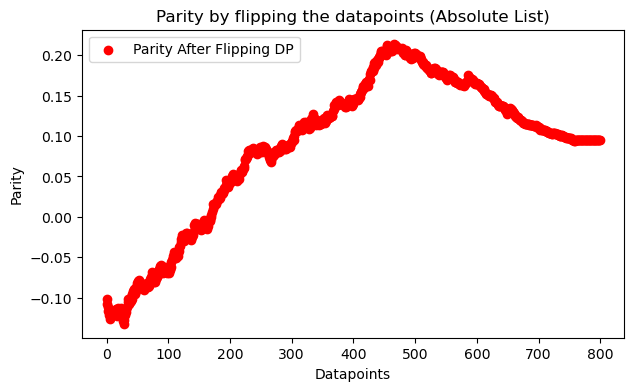

In [48]:
#Graph the points
# Assuming the X-axis is some common range or specific values
size = range(len(flip_parity_abs))  # X values for list data

# Create the plot
plt.figure(figsize=(7, 4))

# Plot list data with dots
plt.scatter(size, flip_parity_abs, color='red', label='Parity After Flipping DP', marker='o')

# Adding labels
plt.xlabel('Datapoints')
plt.ylabel('Parity')

# Adding title and legend
plt.title('Parity by flipping the datapoints (Absolute List)')
plt.legend()

# Display the plot
plt.show()

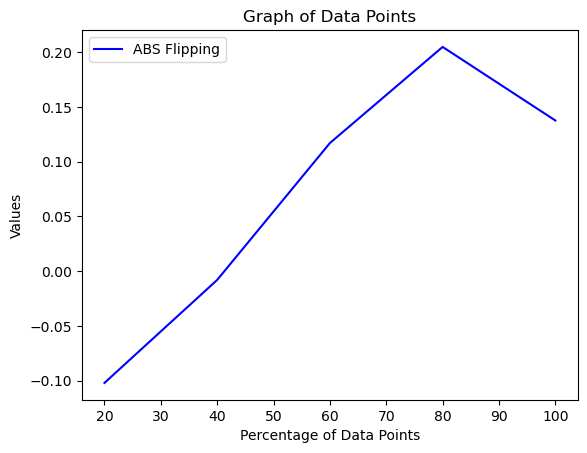

In [49]:
#total num of data points
#on_abs_sorted = len(flip_parity_sorted)
abs_sorted = len(flip_parity_abs)

#Calculate the indices for the 5 points
#indices_non_abs = [int(i * non_abs_sorted / 5) for i in range(0, 5)]
indices_abs = [int(i * abs_sorted / 5) for i in range(0, 5)]

# Extract the values at these indices
#values_non_abs = [flip_parity_sorted[index] for index in indices_non_abs]
values_abs = [flip_parity_abs[index] for index in indices_abs]

#Plot the Values
plt.plot([20, 40, 60, 80, 100], values_abs, label='ABS Flipping', color='Blue')

# Add labels and legend
plt.xlabel('Percentage of Data Points')
plt.ylabel('Values')
plt.title('Graph of Data Points')
plt.legend()

# Show the plot
plt.show()

<h3>Compare methods of: Naive, Entropy, MEU, and IF<h3>

<h5>Naive Method: Greedy Algorithm<h5>

In [50]:
greedy_start = time.time()
#Beginning of the Greedy Algorithm
#Make the original flips to test for the parity after each flip 
greedy_train = train_full_df.copy()
greedy_parity_list = []

for index, row in greedy_train.iterrows():
    if row['credit_risk'] == 1:
        #Flip the label at credit_risk = 1 to 0
        greedy_train.at[index,'credit_risk'] = 0
        greedy_pred = lr_model(greedy_train, X_test, clf)
        greedy_parity = computeFairness(greedy_pred, X_test_orig, y_test, 0, dataset)
        greedy_parity_list.append(greedy_parity)
        greedy_train.at[index,'credit_risk'] = 1
        
    elif row['credit_risk'] == 0:
        greedy_train.at[index,'credit_risk'] = 1
        greedy_pred = lr_model(greedy_train, X_test, clf)
        greedy_parity = computeFairness(greedy_pred, X_test_orig, y_test, 0, dataset)
        greedy_parity_list.append(greedy_parity)
        greedy_train.at[index,'credit_risk'] = 0

KeyboardInterrupt: 

In [50]:
#Compare each of the parity values after flipping to the OG parity value
#Append to a new list

#parity_difference: Contains the difference between flipped and original value
parity_difference = []
#Contains parity values that fall between .03 and -.03
large_influence = []
#Contains the row number of each flip
li_row = []

for value in greedy_parity_list:
    difference = abs(value) - abs(spd_0)
    parity_difference.append(difference)

#Rows considered to be high influence if they in between a specific value
for index, item in enumerate(parity_difference):
  if spd_0 > 0:
    if item <= spd_0 or item >= -1*(spd_0):
        large_influence.append(item)
        li_row.append(index)
  else:
    if item >= spd_0 or item <= -1*(spd_0):
        large_influence.append(item)
        li_row.append(index)

In [51]:
# Combine lists into tuples and zip them
combined_data = list(zip(large_influence, li_row))

# Sort based on statistical parity values in descending order
combined_data.sort(key=lambda x: abs(x[0]), reverse=True)

# Extract sorted indices list and the sorted values
sorted_indices_list = [index for _, index in combined_data]
sorted_values = sorted(large_influence, reverse=True)
greedy_end = time.time()

In [52]:
#After ranking the values now go back through the dataset flipping 
#based on the ranked values

#Parity values after each flip
ranked_greedy_parity_list = []
#Accuracy after every flip
ranked_acc = []
#Index/row of the flip
ranked_flip = []

row_num = 0
ranked_indices_list = list(sorted_indices_list)

#Iterate through the ranked list and start the flipping
for idx, row in enumerate(ranked_indices_list):
    row_num = ranked_indices_list[row]
    #If the label at the specific row is 1 it flips it to 0 then calculates the parity and accuracy
    #It follows the same steps as the flipping before
    if greedy_train.at[row_num,'credit_risk'] == 1:
        greedy_train.at[row,'credit_risk'] = 0
        ranked_greedy_pred = lr_model(greedy_train, X_test, clf)
        ranked_greedy_parity = computeFairness(ranked_greedy_pred, X_test_orig, y_test, 0, dataset)
        ranked_greedy_parity_list.append(ranked_greedy_parity)
    elif greedy_train.at[row_num, 'credit_risk'] == 0:
        greedy_train.at[row, 'credit_risk'] = 1
        ranked_greedy_pred = lr_model(greedy_train, X_test, clf)
        ranked_greedy_parity = computeFairness(ranked_greedy_pred, X_test_orig, y_test, 0, dataset)
        ranked_greedy_parity_list.append(ranked_greedy_parity)

In [53]:
greedy_time = greedy_end - greedy_start
sol_time.append(greedy_time)

<h4>Uncertainty Reduction/Entropy<h4>

In [54]:
entropy_start = time.time()
#Remake the dataset
entropy_train_df = train_full_df.copy()

In [55]:
#Run the LR classifier
#Use Scikit learn logistic regression rather than pre-built one
clfa = LogisticRegression(class_weight=None, max_iter=100)
log = clfa.fit(X_train,y_train)
prediction = log.predict(X_test)
#prediction_prob = log.predict_proba(X_train)
accuracy = accuracy_score(y_test,prediction)*100
print(accuracy)

75.5


In [56]:
#Obtain the predicted probabilities
predicted_prob = log.predict_proba(X_train)

In [57]:
#Log base two would be: log = math.log(x,2)
#Entropy equation would then be: -1*(p1((math.log(p1,2))+p2*(math.log(p2,2)))

#In the predicted_probabilities: first value is 0 (which is bad), second value is 1 (which is good)

#Loop through the predicted_probabilities array and calculate values
#One list will contain the index of each row in the table and the other will contain the entropy value of each row

index_list = []
entropy_list = []

for index, value in enumerate(predicted_prob):
  #Calculate p1 and p2
  p1=predicted_prob[index,0]
  p2=predicted_prob[index,1]
  #Calculate entropy in 3 steps
  entropy_calc1 = p1 * math.log(p1,2)
  entropy_calc2 = p2 * math.log(p2,2)
  entropy_final = -1 * (entropy_calc1 + entropy_calc2)

  #Append the values to their respective lists
  index_list.append(index)
  entropy_list.append(entropy_final)

In [58]:
#Rank the entropy values in decreasing order
#Match the index list with them

#Combine the two lists using zip
combined_list = list(zip(entropy_list, index_list))

#Sort the combined lust based on entropy values in descending order
sorted_list = sorted(combined_list, key = lambda x: x[0], reverse=True)

#Extract the values
sorted_ent_list, sorted_index_list = zip(*sorted_list)
entropy_end = time.time()

In [59]:
entropy_train_df['credit_risk'] = entropy_train_df['credit_risk'].astype('int')

In [60]:
ranked_ent_list = list(sorted_ent_list)
ranked_idx_list = list(sorted_index_list)

In [61]:
#After the ranking; flip based on the ranked entropy values
#Values with the highest entropy are prioritized for flipping

ranked_ent_parity_list = [spd_0]
ranked_flip = []

row_num = 0

#Loop through and flip based on the entropy values
for row in range(len(sorted_index_list)):
    row_num = ranked_idx_list[row]
    if entropy_train_df.at[row_num,'credit_risk'] == 0:
        entropy_train_df.at[row_num,'credit_risk'] = 1
        ranked_ent_pred = lr_model(greedy_train, X_test, clf)
        ranked_ent_parity = computeFairness(ranked_ent_pred, X_test_orig, y_test, 0, dataset)
        ranked_ent_parity_list.append(ranked_ent_parity)

    elif entropy_train_df.at[row_num,'credit_risk'] == 1:
        entropy_train_df.at[row_num,'credit_risk'] = 0
        ranked_ent_pred = lr_model(greedy_train, X_test, clf)
        ranked_ent_parity = computeFairness(ranked_ent_pred, X_test_orig, y_test, 0, dataset)
        ranked_ent_parity_list.append(ranked_ent_parity)

In [62]:
entropy_time = entropy_end - entropy_start
sol_time.append(entropy_time)

<h4>Maximum Expected Utility<h4>

In [63]:
#Copy training dataset
meu_start = time.time()
meu_training_df = train_full_df.copy()

In [64]:
#Obtain the predicted probabilities 
meu_pred_prob = log.predict_proba(X_train)

In [65]:
#Grab the original of the DP in the copy dataframe and sotre in lists along with the index
label = []
row_index = []
for index, row in meu_training_df.iterrows():
    label.append(meu_training_df.at[index,'credit_risk'])
    row_index.append(index)

In [66]:
#Calculate the first part of the MEU equation
meu_part1_list = []
for index, value in enumerate(label):
    if value == 1:
        prob1 = meu_pred_prob[index,1]
        meu_part1_calc = prob1 * spd_0
        meu_part1_list.append(meu_part1_calc)
    elif value == 0:
        prob2 = meu_pred_prob[index,0]
        meu_part1_calc = prob2 * spd_0
        meu_part1_list.append(meu_part1_calc)

In [67]:
#Iterate through the copied dataset and flip each lable and calculate the parity

meu_part2_parity_list = []

for idx, row in meu_training_df.iterrows():
    #If the row is positive then flip it to negative
    if row['credit_risk'] == 1:
        meu_training_df.at[index,'credit_risk']= 0
        meu_pred = lr_model(meu_training_df, X_test, clf)
        meu_parity = computeFairness(meu_pred, X_test_orig, y_test, 0, dataset)
        meu_part2_parity_list.append(meu_parity)
        meu_training_df.at[index,'credit_risk'] = 1
    #If negative then flip to positive
    elif row['credit_risk'] == 0:
        meu_training_df.at[index,'credit_risk']= 1
        meu_pred = lr_model(meu_training_df, X_test, clf)
        meu_parity = computeFairness(meu_pred, X_test_orig, y_test, 0, dataset)
        meu_part2_parity_list.append(meu_parity)
        meu_training_df.at[index,'credit_risk'] = 0
        

In [68]:
#Second part of the calculation by taking the opposite value
meu_part2_list = []
for index, value in enumerate(label):
    if value == 0:
        prob0 = meu_pred_prob[index,0]
        meu_part2_calc = prob0* meu_part2_parity_list[index]
    elif value == 1:
        prob1 = meu_pred_prob[index,1]
        meu_part2_calc = prob1 * meu_part2_parity_list[index]
        meu_part2_list.append(meu_part2_calc)


In [69]:
#Add the two lists together
expected_utility_values = []
for part1, part2 in zip(meu_part1_list, meu_part2_list):
    expected_utility_values.append(part1+part2)

In [70]:
#EU - OG Parity = new ranked values
new_ranked_value = []

for value in expected_utility_values:
    new_ranked_value.append(value - spd_0)

In [71]:
#Rank the values
combined_list = list(zip(new_ranked_value,row_index))
sorted_list = sorted(combined_list, key = lambda x: abs(x[0]), reverse=True)
sorted_eu_list, sorted_index_list = zip(*sorted_list)
meu_end = time.time()

In [72]:
#After ranking flip the values
meu_ranked_parity_list = [spd_0]

for row in range(len(sorted_index_list)):
    row_num = sorted_index_list[row]
    
    if meu_training_df.at[row_num,'credit_risk'] == 1:
        meu_training_df.at[row_num, 'credit_risk'] = 0
        meu_pred = lr_model(meu_training_df, X_test, clf)
        meu_ranked_parity = computeFairness(meu_pred, X_test_orig, y_test, 0, dataset)
        meu_ranked_parity_list.append(meu_ranked_parity)
    elif meu_training_df.at[row_num, 'credit_risk'] == 0:
        meu_training_df.at[row_num, 'credit_risk'] = 1
        meu_pred = lr_model(meu_training_df, X_test, clf)
        meu_ranked_parity = computeFairness(meu_pred, X_test_orig, y_test, 0, dataset)
        meu_ranked_parity_list.append(meu_ranked_parity)

In [73]:
meu_time = meu_end - meu_start
sol_time.append(meu_time)

<h4>Randomized flipping<h4>

In [74]:
#Training dataset
random_start = time.time()
random_training_df = train_full_df.copy()

In [75]:
#Budget of 200 random flipping
import random
random_flip_parity = []
budget = len(y_test)

for iter in range(budget):
    random_row = random.choice(random_training_df.index)
    if random_training_df.at[random_row,'credit_risk'] == 1:
        random_training_df.at[random_row,'credit_risk'] = 0
        rand_pred = lr_model(random_training_df, X_test, clf)
        rand_ranked_parity = computeFairness(rand_pred, X_test_orig, y_test, 0, dataset)
        random_flip_parity.append(rand_ranked_parity)
    elif random_training_df.at[random_row,'credit_risk'] == 0:
        random_training_df.at[random_row,'credit_risk'] = 1
        rand_pred = lr_model(random_training_df, X_test, clf)
        rand_ranked_parity = computeFairness(rand_pred, X_test_orig, y_test, 0, dataset)
        random_flip_parity.append(rand_ranked_parity)
random_end = time.time()


In [76]:
random_time = random_end - random_start
sol_time.append(random_time)

In [77]:
if_start

1726345264.6297765

<h4>Graph of outcomes<h4>

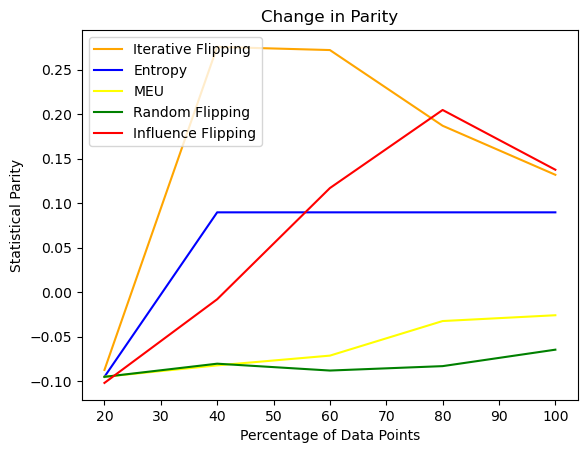

In [78]:
# Calculate the total number of data points
datapoints_iterative = len(ranked_greedy_parity_list)
datapoints_entropy = len(ranked_ent_parity_list)
datapoints_meu = len(meu_ranked_parity_list)
datapoints_random = len(random_flip_parity)
datapoints_influence = len(flip_parity_abs)

# Calculate the indices for the 5 points
indices_iterative = [int(i * datapoints_iterative / 5) for i in range(0, 5)]
indices_entropy = [int(i * datapoints_entropy / 5) for i in range(0, 5)]
indices_meu = [int(i * datapoints_meu / 5) for i in range(0, 5)]
indices_random = [int(i * datapoints_random / 5) for i in range(0, 5)]
indices_influence = [int(i * datapoints_influence / 5) for i in range(0, 5)]

# Extract the values at these indices
values_iterative = [ranked_greedy_parity_list[index] for index in indices_iterative]
values_entropy = [ranked_ent_parity_list[index] for index in indices_entropy]
values_meu = [meu_ranked_parity_list[index] for index in indices_meu]
values_random = [random_flip_parity[index] for index in indices_random]
values_influence = [flip_parity_abs[index] for index in indices_influence]

# Plot the values
plt.plot([20, 40, 60, 80, 100], values_iterative, label='Iterative Flipping', color='Orange')
plt.plot([20, 40, 60, 80, 100], values_entropy, label='Entropy', color='Blue')
plt.plot([20, 40, 60, 80, 100], values_meu, label='MEU', color='Yellow')
plt.plot([20, 40, 60, 80, 100], values_random, label='Random Flipping', color='Green')
plt.plot([20, 40, 60, 80, 100], values_influence, label='Influence Flipping', color='Red')

# Add labels and legend
plt.xlabel('Percentage of Data Points')
plt.ylabel('Statistical Parity')
plt.title('Change in Parity')
plt.legend()

<h4>Time Comparisons<h4>

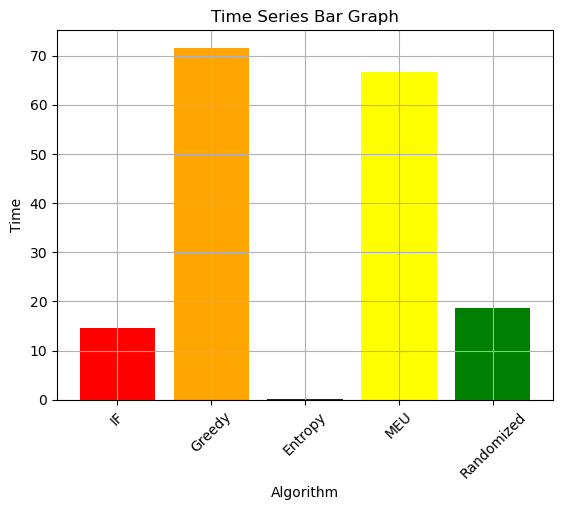

In [79]:
# Create a line chart
x_axis = ['IF', 'Greedy', 'Entropy', 'MEU', 'Randomized']
# Colors for each bar
colors = ['red', 'orange', 'blue', 'yellow', 'green']

# Create a bar graph with updated labels and colors
plt.bar(x_axis, sol_time, color=colors)
plt.title('Time Series Bar Graph')
plt.xlabel('Algorithm')
plt.ylabel('Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [80]:
#When calculating the time we are looking at the time taken to choose which datapoint to flip 
#Do not consider the time taken to calculate the fairness on each datapoint
#Also when implementing the other solutions on the bigger datasets do not implement MEU and greedy due to the expense of it
#Instead implement IF, Entropy, and randomized

#Since our solution is looking to determine the efficiency at which the datapoints are selected we want to measure the time 
#taken to determine which order the datapoints should be flipped in
#Measure how long it takes to determine which datapoints need to be flipping and do not consider the parity calculations
print(sol_time)

[14.517300844192505, 71.58307433128357, 0.08031129837036133, 66.68825149536133, 18.599604606628418]
